In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.lines as mlines
import seaborn as sns
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
from patsy import dmatrices, dmatrix
import matplotlib.pyplot as plt
from scipy.optimize import fmin_powell
from scipy import integrate,optimize
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc

In [2]:
dfs = pd.read_csv('AllVariables.csv',index_col=0)

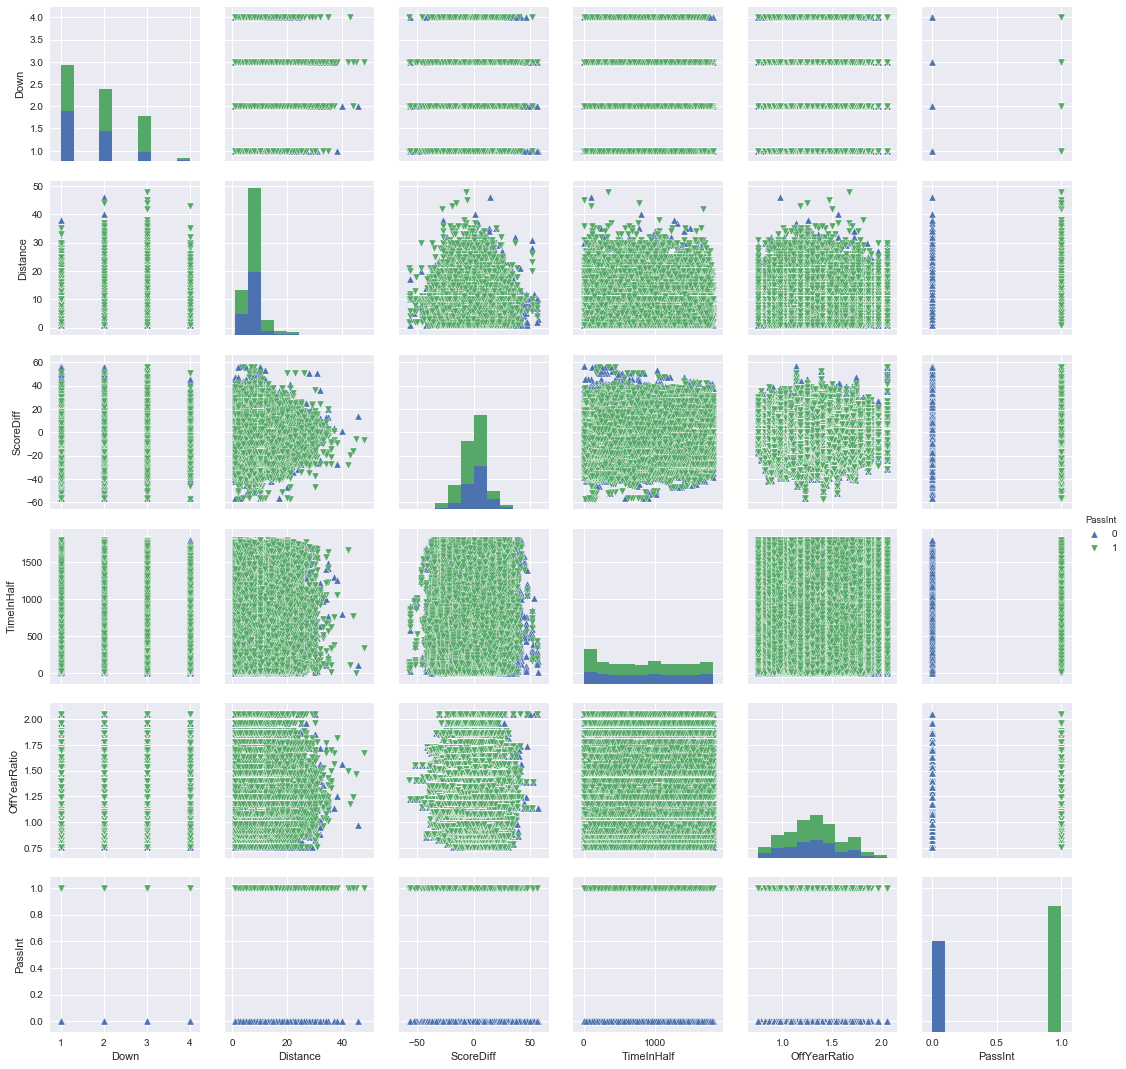

In [3]:
splot = sns.pairplot(dfs[['Down','Distance','ScoreDiff','TimeInHalf','OffYearRatio','PassInt']],
                     hue='PassInt',markers=['^','v'])

In [4]:
dfs['Distance2'] = np.square(dfs['Distance'])
dfs['Distance2Reg'] = (dfs['Distance2']-dfs['Distance2'].mean(0))/dfs['Distance2'].std()
dfs['DistanceReg'] = (dfs['Distance']-dfs['Distance'].mean(0))/dfs['Distance'].std()
dfs['ScoreDiffReg'] = (dfs['ScoreDiff']-dfs['ScoreDiff'].mean(0))/dfs['ScoreDiff'].std()
dfs['OffYearRatioReg'] = (dfs['OffYearRatio']-dfs['OffYearRatio'].mean(0))/dfs['OffYearRatio'].std()
dfs['TimeInHalfReg'] = (dfs['TimeInHalf']-dfs['TimeInHalf'].mean(0))/dfs['TimeInHalf'].std()
dfs['DefYearRatioReg'] = (dfs['DefYearRatio']-dfs['DefYearRatio'].mean(0))/dfs['DefYearRatio'].std()
dfs['YardsToGoalReg'] = (dfs['YardsToGoal']-dfs['YardsToGoal'].mean(0))/dfs['YardsToGoal'].std()

In [5]:
msk = np.random.rand(len(dfs)) < 0.8
train = dfs[msk].copy()
test = dfs[~msk].copy()
print('Training set: {0} Testing set: {1}'.format(len(train),len(test)))
passcompare = test['PassInt'].values

Training set: 156562 Testing set: 39177


In [6]:
np.random.seed(7)
formula = 'PassInt ~ Down + DistanceReg + ScoreDiffReg + \
           TimeInHalfReg + OffYearRatioReg + DefYearRatioReg + YardsToGoalReg'
y,x = dmatrices(formula, data=dfs, return_type='matrix')
x = x[:,1:]
X = np.asarray(x)
y = np.asarray(y)
y = y.flatten()
n_sample = len(X)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)
X = X[:n_sample]
y = y[:n_sample]
ninety_percent_of_sample = int(.9 * n_sample)
X_train = X[:ninety_percent_of_sample]
y_train = y[:ninety_percent_of_sample]
X_test = X[ninety_percent_of_sample:]
y_test = y[ninety_percent_of_sample:]
reg = LogisticRegression()

In [7]:
reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
y_2 = reg.predict(X_test)
n = len(y_test)
print('The efficiency is: {0}'.format(float(sum([int(y_test[i]==y_2[i]) for i in range(0,n)]))/n))
print('The coefficients are: '+str(reg.coef_))

The efficiency is: 0.651987330132
The coefficients are: [[ 0.80608269  0.44023856 -0.36459299 -0.11652003  0.07853538  0.00308445
  -0.00325444]]


In [12]:
with pm.Model() as logistic_model:
    pm.glm.glm('PassInt ~ Down + DistanceReg + ScoreDiffReg + \
           TimeInHalfReg + OffYearRatioReg + DefYearRatioReg + YardsToGoalReg', 
               train,
               family=pm.glm.families.Binomial(),
               init_vals={'Down':0.80417211,
                          'DistanceReg':0.43832322,
                          'ScoreDiffReg':-0.36676145,
                          'TimeInHalfReg':-0.11699557}
              )
    trace = pm.sample(1000, step=pm.NUTS()
                       ,start=pm.find_MAP(fmin=optimize.fmin_powell)
                       ,trace=pm.backends.Text('trc_first/trueFull1000')
                     )

/usr/local/lib/python2.7/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 97610.299577
         Iterations: 6
         Function evaluations: 659


100%|██████████| 1000/1000 [13:24<00:00,  2.02it/s]


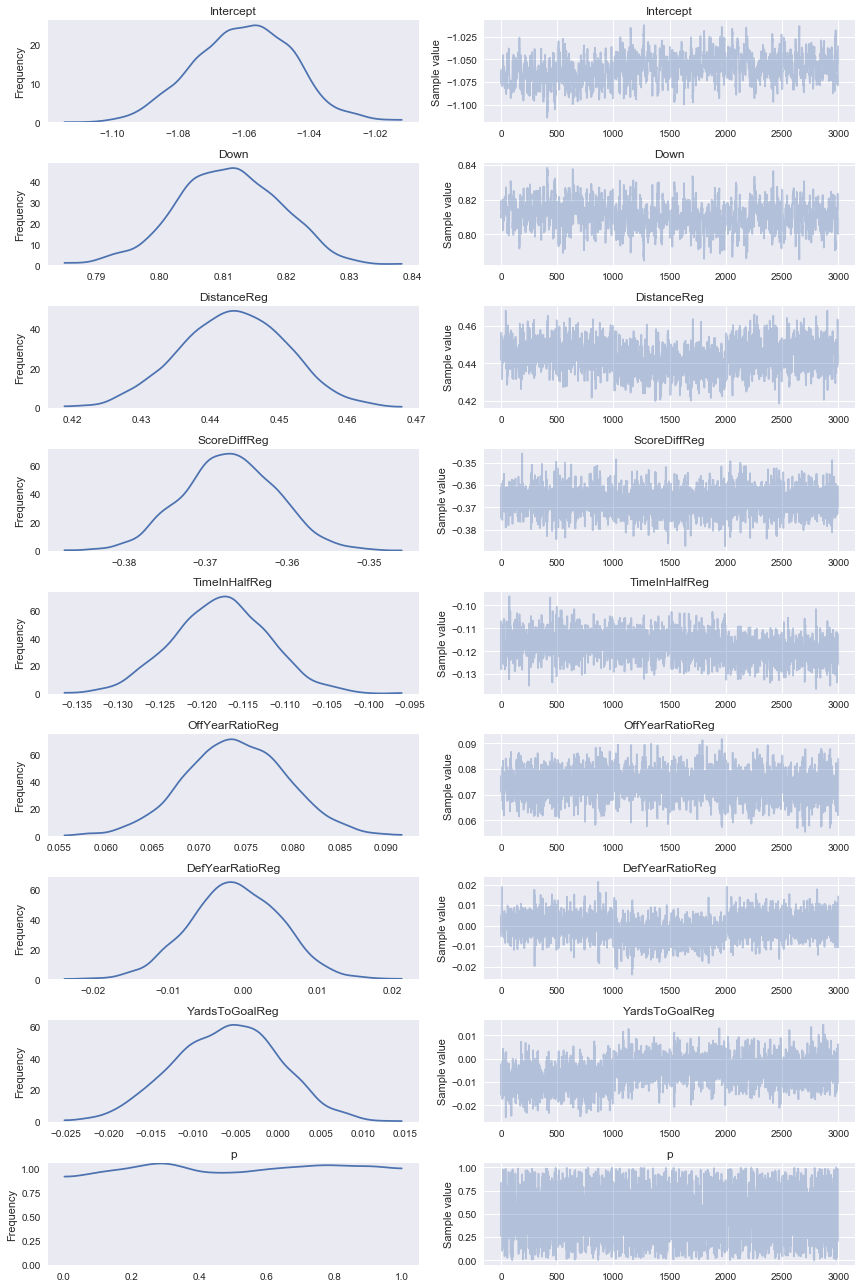

In [13]:
with logistic_model:
    pm.traceplot(trace)

In [14]:
lm1 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['ScoreDiffReg']*x +
                                          samples['Down']*1 +
                                          samples['DistanceReg']*0 + 
                                          samples['TimeInHalfReg']*0 +
                                          samples['OffYearRatioReg']*0
                                          )))


lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['ScoreDiffReg']*x +
                                          samples['Down']*2 +
                                          samples['DistanceReg']*0 +
                                          samples['TimeInHalfReg']*0 +
                                          samples['OffYearRatioReg']*0
                                          )))

lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['ScoreDiffReg']*x +
                                          samples['Down']*3 +
                                          samples['DistanceReg']*0 +
                                          samples['TimeInHalfReg']*0 +
                                          samples['OffYearRatioReg']*0
                                          )))


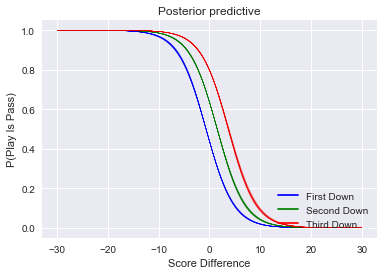

In [15]:
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(-30, 30, 1000), lm=lm1, samples=100, color="blue", alpha=.15)
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(-30, 30, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(-30, 30, 1000), lm=lm3, samples=100, color="red", alpha=.15)
blue_line = mlines.Line2D(['lm1'], [], color='b', label='First Down')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Second Down')
red_line = mlines.Line2D(['lm3'], [], color='r', label='Third Down')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Play Is Pass)")
plt.xlabel("Score Difference")
plt.show()

In [16]:
df_trace = pm.trace_to_dataframe(trace)

In [17]:
df_trace.to_csv('tracerFull.csv')

In [11]:
df_trace = pd.read_csv('tracerFull.csv',index_col=None)

In [12]:
test['index'] = test.index
test['key']=1
df_trace['key']=1

In [13]:
df = pd.merge(test,df_trace,on='key')

In [14]:
df['coef'] = df['Intercept'] + df.DistanceReg_y*df.DistanceReg_x + \
        df.ScoreDiffReg_y*df.ScoreDiffReg_x + df.Down_x*df.Down_y + \
        df.TimeInHalfReg_x*df.TimeInHalfReg_y + df.OffYearRatioReg_x*df.OffYearRatioReg_y + \
        df.DefYearRatioReg_x*df.DefYearRatioReg_y + df.YardsToGoalReg_x*df.YardsToGoalReg_y

In [15]:
df['Resulted'] = (1/(1+np.exp(-df['coef'])))

In [ ]:
pred = df.groupby(['index']).sum().reset_index()

In [ ]:
pred['PassInt'] = pred['PassInt']/len(df_trace)
pred['Resulted']= pred['Resulted']/len(df_trace)
pred['IsCorrect'] = (pred['PassInt']==(pred['Resulted']>0.5))*1

In [ ]:
n = len(pred)

In [ ]:
print("The accuracy is: "+str(float(pred['IsCorrect'].sum())/len(pred))+ \
      "\n The log loss is: "+str(float(sum([-pred['PassInt']*np.log(pred['Resulted'])-
                            (1-pred['PassInt'])*np.log(1-pred['Resulted']) for i in range(0,n)]))/n))

In [ ]:
pred.to_csv('BayesForContrarian.csv')